In [ ]:
USING_COLAB = True # allows to download files from drive when using Google Colab

if USING_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    x_train_downloaded = drive.CreateFile({'id':"1llrLRCwI6gvaTOgGcGl1aigk_97HFW6D"})
    y_train_downloaded = drive.CreateFile({'id':"165kNBNGxqvoSbWoYVhuZNfhJ_MKUxUXB"})
    x_test_downloaded = drive.CreateFile({'id':"1xXEKoy1W1MWUOURUBp_QsZvEpyzwAzIL"})

    x_train_downloaded.GetContentFile('x-train.csv')
    y_train_downloaded.GetContentFile('y-train.csv')
    x_test_downloaded.GetContentFile('x-test.csv')

# Preparing the environment

In [ ]:
import platform

print(f"Python version: {platform.python_version()}")

Python version: 3.7.12


In [ ]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Numpy version: 1.19.5
Pandas version: 1.1.5


In [ ]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 15, 8
%config InlineBackend.figure_format = "retina"
sns.set(font_scale = 1)

# Setup warnings
import warnings
warnings.filterwarnings('ignore')

# Data processing

In [ ]:
#3. Read file as panda dataframes

x_train = pd.read_csv('x-train.csv', index_col=0, sep=",")
y_train = pd.read_csv('y-train.csv', index_col=0, sep=",")
x_test = pd.read_csv('x-test.csv', index_col=0, sep=",")

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(110854, 289)
(110854, 248)
(47615, 289)


In [ ]:
test_challengeIDs = x_test.index

x_train_tags = x_train.iloc[:,:248]
x_test_tags = x_test.iloc[:,:248]

print(x_train_tags.shape)
print(x_test_tags.shape)


(110854, 248)
(47615, 248)


In [ ]:
x_train_tags.head()

,acid-jazz,alternative-rock,americana,blaxpoitation,bluegrass,blues-rock,bossa-nova,breakbeat,chill-out,classic-ambient,classical,contemporary-classical,contemporary-folk,contemporary-jazz,contemporary-pop,contemporary-rnb,country-blues,country-folk,country-pop,country-rock,drones,drum-n-bass,dubstep,easy-listening,edm,electro,electro-rock,electronica,film-score,folk-rock,funk-rock,garage-rock,gospel,hard-rock,heavy-metal,hip-hop,house,indie-folk,indie-pop,indie-rock,...,confident,creepy,dangerous,driving,epic,euphoric,exciting,fragile,funny,happy,hate,heartfelt,hopeful,hot,inspirational,joyful,majestic,moody,motivational,mysterious,optimistic,playful,poignant,quiet,rebellion,reflective,relaxed,romantic,sad,seductive,serious,sexy,sinister,sneaky,spectacular,suspenseful,togetherness,uplifting,victorious,warm
ChallengeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000023,0.006455,0.001339,0.000159,0.000045,0.000191,0.000087,0.014584,0.007135,0.010316,0.018971,0.023930,0.001575,0.007633,0.000264,0.000113,0.000028,0.000077,0.000089,0.000549,0.013441,0.000548,0.014392,0.000749,0.013649,0.025120,0.013824,0.320161,0.352349,0.000550,0.000223,0.000868,0.000026,0.002960,0.005464,0.003563,0.003888,0.000515,0.007536,0.047376,...,0.211743,0.072327,0.123655,0.303483,0.373634,0.004816,0.057950,0.012691,0.003431,0.005795,0.002479,0.015942,0.006034,0.000525,0.018965,0.000110,0.551669,0.006720,0.011968,0.096827,0.035847,0.010067,0.001312,0.000773,0.039394,0.009052,0.010603,0.001459,0.020250,0.001135,0.208697,0.003649,0.477274,0.021050,0.598789,0.561859,0.000011,0.031976,0.015408,0.003196
1,0.000069,0.056431,0.008977,0.000347,0.000536,0.001447,0.000093,0.047316,0.019435,0.005939,0.014535,0.006807,0.007178,0.090392,0.007400,0.002443,0.000128,0.000516,0.007802,0.018544,0.004532,0.000482,0.007520,0.005222,0.069116,0.011084,0.045196,0.266084,0.031419,0.002735,0.000852,0.008483,0.000664,0.007904,0.005491,0.021351,0.003329,0.002039,0.103383,0.161913,...,0.364563,0.007447,0.013157,0.291642,0.165729,0.020066,0.042831,0.028966,0.002803,0.042065,0.000552,0.055792,0.017489,0.001067,0.023915,0.000322,0.398454,0.004264,0.051764,0.016474,0.238344,0.012912,0.001747,0.003555,0.019349,0.019380,0.076518,0.006833,0.017539,0.003759,0.141124,0.005256,0.079180,0.004069,0.428932,0.175797,0.000041,0.169048,0.030058,0.025905
2,0.000039,0.017784,0.001067,0.000290,0.000021,0.001512,0.000033,0.109496,0.008511,0.009775,0.009322,0.031179,0.000364,0.007926,0.000307,0.000108,0.000062,0.000048,0.000079,0.000997,0.031112,0.000675,0.047684,0.000483,0.011581,0.044310,0.131119,0.493381,0.177750,0.000515,0.001371,0.009730,0.000021,0.071293,0.076663,0.016110,0.001789,0.000113,0.003392,0.080414,...,0.125003,0.073964,0.123163,0.521188,0.283021,0.003213,0.112006,0.003378,0.001500,0.003472,0.006628,0.003366,0.002135,0.000155,0.032166,0.000060,0.426780,0.001623,0.006711,0.037691,0.016082,0.003348,0.000452,0.000219,0.131564,0.002715,0.003165,0.000485,0.006237,0.000488,0.129773,0.002660,0.596533,0.012951,0.605012,0.576786,0.000005,0.021769,0.011692,0.000589
3,0.000047,0.004563,0.000289,0.000520,0.000013,0.000264,0.000026,0.265472,0.004216,0.002639,0.005890,0.012286,0.000184,0.013583,0.000547,0.000179,0.000009,0.000027,0.000054,0.000189,0.004560,0.001822,0.114699,0.000535,0.081488,0.054893,0.155983,0.647314,0.049505,0.000153,0.002081,0.003098,0.000016,0.012174,0.019197,0.013123,0.025651,0.000058,0.004323,0.033185,...,0.194559,0.057359,0.194631,0.612274,0.146257,0.009272,0.159114,0.005298,0.001772,0.005632,0.019334,0.003714,0.004627,0.000551,0.043030,0.000100,0.285886,0.004379,0.017688,0.038168,0.033406,0.003419,0.000653,0.000418,0.147744,0.004924,0.006005,0.000880,0.009205,0.001669,0.111747,0.009034,0.579008,0.008083,0.678286,0.472103,0.000016,0.038149,0.013244,0.001117
4,0.000022,0.006412,0.001309,0.000204,0.000025,0.001302,0.000039,0.008771,0.001732,0.003859,0.022517,0.060648,0.000330,0.009634,0.000212,0.000057,0.000035,0.000059,0.000048,0.000386,0.

In [ ]:
x_test_tags.head()

,acid-jazz,alternative-rock,americana,blaxpoitation,bluegrass,blues-rock,bossa-nova,breakbeat,chill-out,classic-ambient,classical,contemporary-classical,contemporary-folk,contemporary-jazz,contemporary-pop,contemporary-rnb,country-blues,country-folk,country-pop,country-rock,drones,drum-n-bass,dubstep,easy-listening,edm,electro,electro-rock,electronica,film-score,folk-rock,funk-rock,garage-rock,gospel,hard-rock,heavy-metal,hip-hop,house,indie-folk,indie-pop,indie-rock,...,confident,creepy,dangerous,driving,epic,euphoric,exciting,fragile,funny,happy,hate,heartfelt,hopeful,hot,inspirational,joyful,majestic,moody,motivational,mysterious,optimistic,playful,poignant,quiet,rebellion,reflective,relaxed,romantic,sad,seductive,serious,sexy,sinister,sneaky,spectacular,suspenseful,togetherness,uplifting,victorious,warm
ChallengeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
110854,0.000039,0.000702,0.002267,0.000046,0.000010,0.000133,0.000048,0.001051,0.048711,0.023882,0.000905,0.031192,0.000387,0.011311,0.001413,0.000110,0.000091,0.000051,0.000008,0.000031,0.923124,0.000180,0.000137,0.001392,0.000543,0.000528,0.000297,0.148556,0.006016,0.000559,0.000012,0.000081,0.000340,0.000327,0.000228,0.000275,0.000126,0.001390,0.000357,0.001490,...,0.037067,0.169044,0.058648,0.028218,0.016199,0.000338,0.006095,0.006241,0.000393,0.000899,0.002602,0.009447,0.003061,0.000636,0.005899,0.000058,0.056362,0.021066,0.000867,0.441424,0.004982,0.001344,0.002520,0.002947,0.000787,0.042935,0.060493,0.003511,0.062804,0.003229,0.149392,0.002233,0.719409,0.039949,0.053341,0.407447,0.000079,0.004271,0.001739,0.002973
110855,0.000030,0.003561,0.000584,0.000018,0.000015,0.000028,0.000293,0.000548,0.409495,0.498671,0.013834,0.013949,0.002373,0.142399,0.001722,0.000542,0.000009,0.000062,0.000024,0.000032,0.129805,0.000150,0.000594,0.008402,0.014540,0.013134,0.000137,0.575747,0.113329,0.000515,0.000011,0.000083,0.000188,0.000040,0.000042,0.000192,0.003723,0.000916,0.039390,0.012412,...,0.024532,0.001884,0.000313,0.007589,0.012269,0.009072,0.001157,0.304770,0.001304,0.040530,0.000071,0.457325,0.104576,0.003771,0.025766,0.001177,0.016794,0.029954,0.010384,0.014715,0.149596,0.005759,0.027871,0.177834,0.000176,0.167461,0.855960,0.110748,0.110579,0.019392,0.032205,0.003727,0.019280,0.000376,0.005860,0.005172,0.003073,0.185740,0.004092,0.687251
110856,0.000056,0.003282,0.013096,0.000023,0.000068,0.000130,0.000210,0.000204,0.303434,0.023081,0.010880,0.369200,0.003871,0.036413,0.008752,0.000217,0.000133,0.000579,0.000096,0.000157,0.188493,0.000199,0.000154,0.013753,0.002054,0.000245,0.000146,0.097394,0.026540,0.002472,0.000007,0.000058,0.001072,0.000097,0.000029,0.000056,0.000289,0.006209,0.003520,0.001895,...,0.030421,0.032845,0.003466,0.009735,0.052919,0.001169,0.006298,0.014307,0.003246,0.016713,0.000312,0.020337,0.035988,0.020737,0.050362,0.005685,0.127100,0.026744,0.004255,0.105806,0.058273,0.013502,0.075625,0.099107,0.000043,0.292813,0.420852,0.180743,0.215313,0.014195,0.031979,0.004013,0.089705,0.004161,0.011090,0.069018,0.009103,0.055369,0.011555,0.167065
110857,0.000588,0.004894,0.001013,0.000055,0.000020,0.000394,0.000122,0.001343,0.251494,0.016740,0.003040,0.560912,0.000433,0.017350,0.025126,0.000492,0.000069,0.000141,0.000075,0.000271,0.084304,0.000955,0.000554,0.013428,0.010479,0.003935,0.002778,0.438061,0.004517,0.001203,0.000082,0.000104,0.000143,0.000715,0.000104,0.000337,0.002990,0.000595,0.002130,0.016887,...,0.125395,0.006592,0.002527,0.092987,0.008050,0.005764,0.060488,0.003144,0.051139,0.115006,0.000309,0.011310,0.015167,0.002118,0.050029,0.053021,0.055372,0.002046,0.007120,0.050142,0.224987,0.147662,0.009505,0.031164,0.000339,0.062319,0.126137,0.013273,0.024643,0.002454,0.009253,0.001780,0.011440,0.002537,0.023365,0.024079,0.000406,0.088998,0.008622,0.120786
110858,0.000963,0.002342,0.005915,0.000180,0.000018,0.008012,0.000117,0.000923,0.187764,0.012836,0.002024,0.062109,0.000196,0.044587,0.002328,0.001433,0.001415,0.00

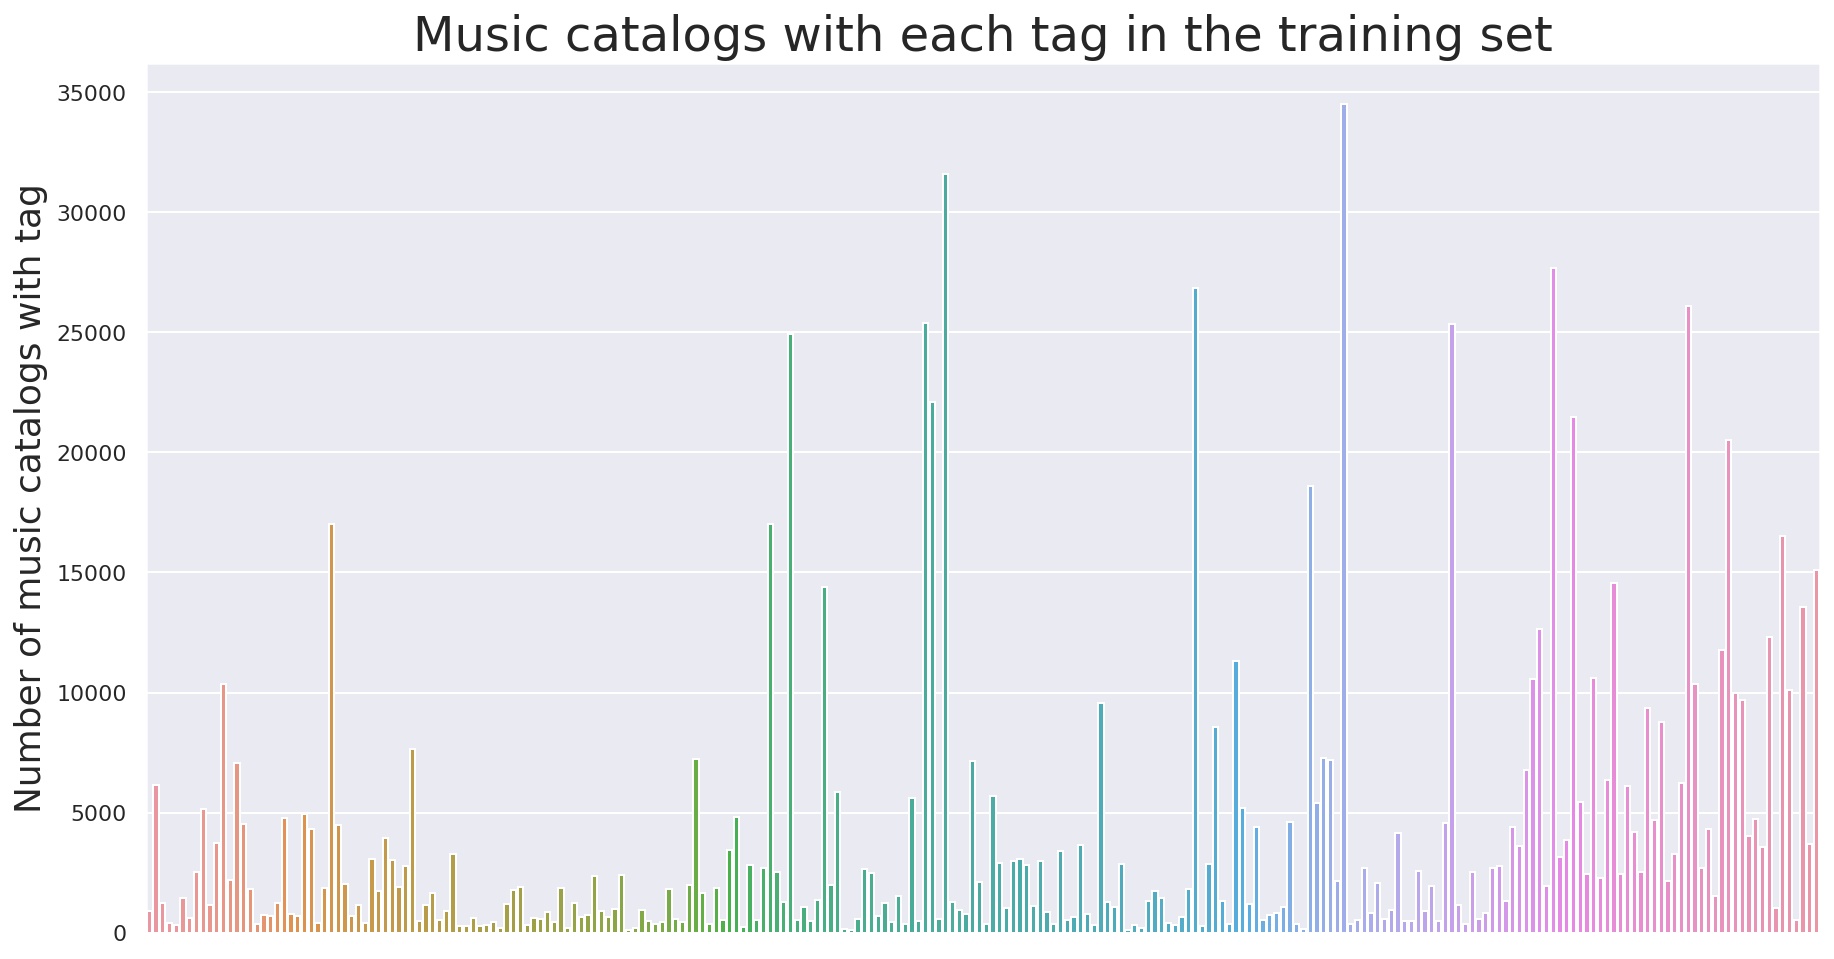

In [ ]:
tags = list(y_train.columns.values)
n_tags = len(tags)
ax= sns.barplot(x=tags, y=y_train.sum().values)
plt.title("Music catalogs with each tag in the training set", fontsize=24)
plt.ylabel("Number of music catalogs with tag", fontsize=18)
ax.axes.get_xaxis().set_visible(False)

plt.show()

# Trying different classification methods

## Method 1: Trying diffrent threshold values on each column

In [ ]:
def get_best_threshold(x, y, col):
    test_thresholds = np.arange(0, 1, 0.01)
    scores = []
    for threshold in test_thresholds:
        decisions = (x.iloc[:, col] > threshold).astype(int)
        scores.append(f1_score(y.iloc[:, col], decisions, average="weighted"))
    return test_thresholds[np.argmax(scores)]

In [ ]:
thresholds  = [get_best_threshold(x_train_tags, y_train, col) for col in tqdm(range(n_tags))]
y_test = (x_test_tags > thresholds).astype(int)

  0%|          | 0/248 [00:00<?, ?it/s]

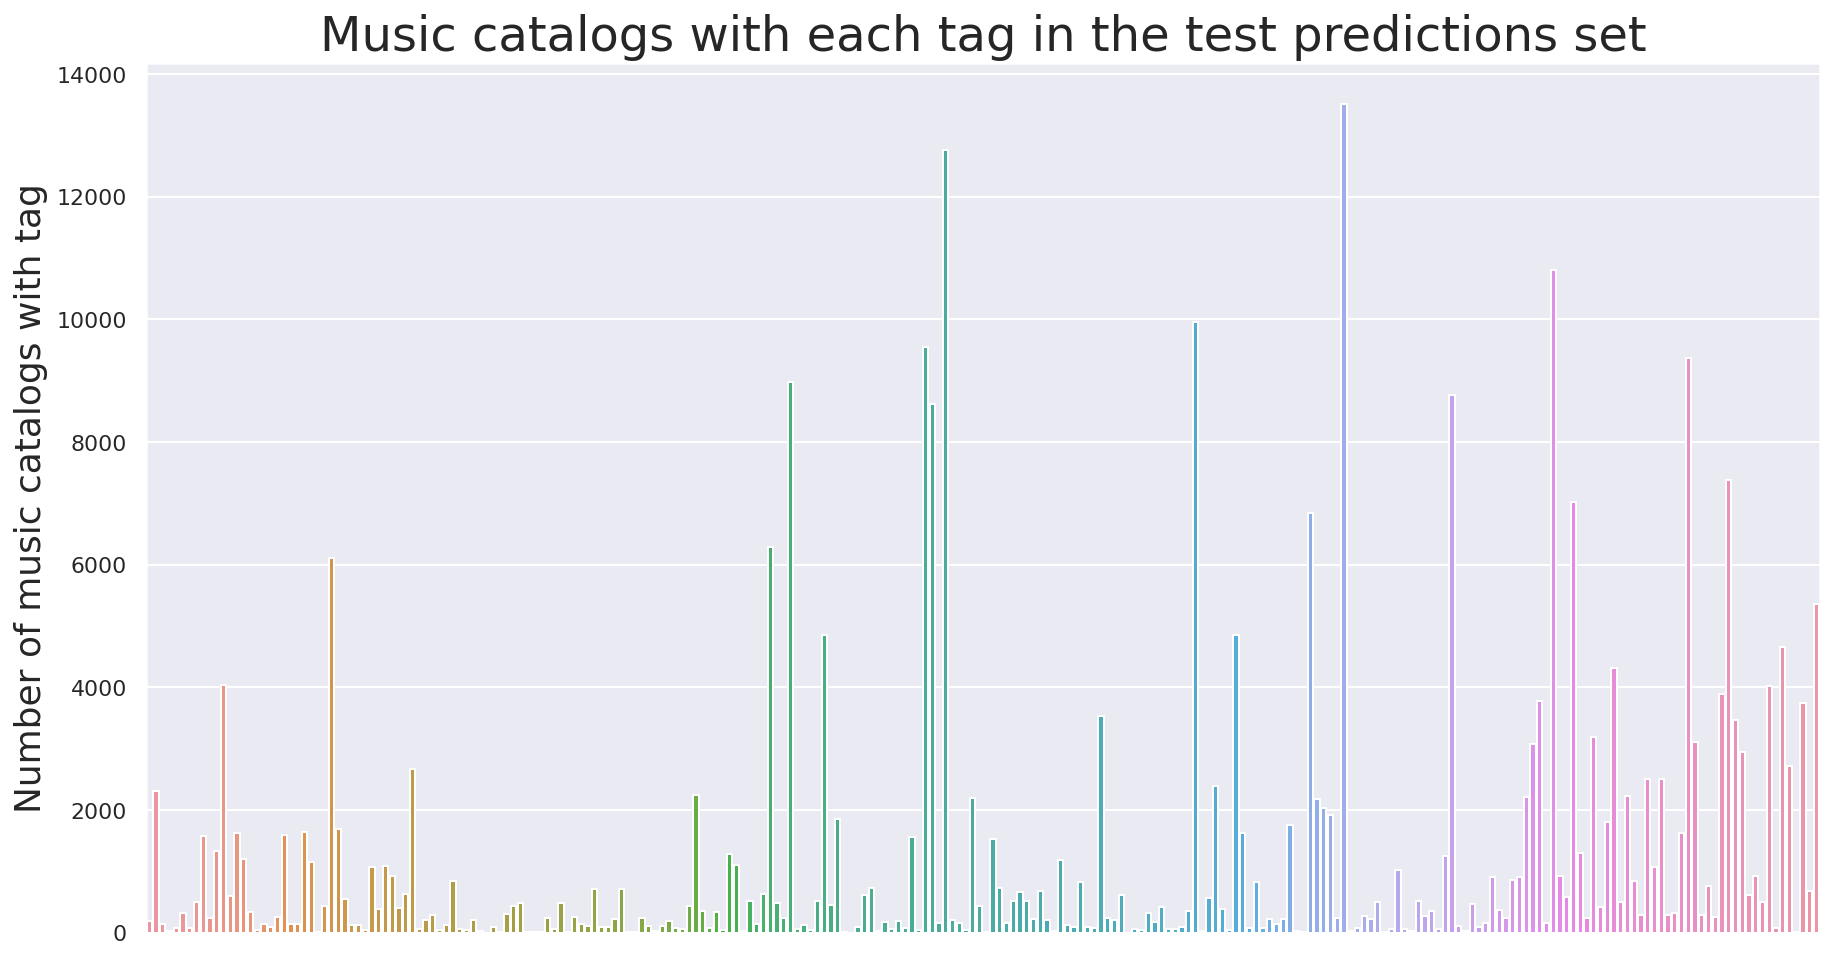

In [ ]:
ax= sns.barplot(x=tags, y=y_test.sum().values)
plt.title("Music catalogs with each tag in the test predictions set", fontsize=24)
plt.ylabel("Number of music catalogs with tag", fontsize=18)
ax.axes.get_xaxis().set_visible(False)

plt.show()

In [ ]:
submission_time = time.strftime("%d-%m-%Y_%H-%M")
y_test.to_csv(f"submission-{submission_time}.csv", index=False)
print(submission_time)

10-12-2021-10:48


## Method 2: OneVsRestClassifier with Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

In [ ]:
y_test = pd.DataFrame(test_challengeIDs)
for tag in tqdm(x_train_tags.columns.values, desc="Processing catalogs"):
    pipeline.fit(x_train_tags, y_train[tag])
    y_test[tag] = pipeline.predict(x_test_tags)

Processing catalogs:   0%|          | 0/248 [00:00<?, ?it/s]

In [ ]:
submission_time = time.strftime("%d-%m-%Y_%H-%M")
y_test.to_csv(f"submission-{submission_time}.csv", index="False")
print(submission_time)

10-12-2021-11:28


## Method 3: Using k-cross validation with other classifiers

In [ ]:
# Istall scikit-multilearn if not already done
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 4.4 MB/s 


In [16]:
import json
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain    

scores = {}
models = {
    "MLPClassifier" : MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=200,activation = 'relu',solver='adam',random_state=1),
    "BinaryRelevance" : BinaryRelevance(GaussianNB()),
    "ClassifierChain" : ClassifierChain(LogisticRegression()),
    "LabelPowerset" : LabelPowerset(LogisticRegression())
}
data_portion = 20000 # Modify this to train and test on only a portion of the data. 0 < data_portion < x_train_tags.shape[0]

for model_name in models.keys():
    model = models[model_name]
    try:
        scores[model_name] = cross_val_score(model, x_train_tags.iloc[:data_portion, :], y_train.iloc[:data_portion, :], n_jobs=-1, verbose=1, cv=5).tolist()
        with open("log.txt", 'a') as log_file:
            print(f"The model {model_name} finished with a score of : {scores[model_name]}", file=log_file)
    except Exception as ex:
        with open("log.txt", 'a') as log_file:
            print(f"A {type(ex).__name__} exception with arguments ({ex.args}) occured during training of the model {model_name}", file=log_file)
        continue

with open('scores.json', 'w') as scores_file:
    json.dump(scores, scores_file)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.7min finished


# In case you want to modify a submission's file

In [ ]:
submission_filename = "submission-10-12-2021-10_48.csv"
df = pd.read_csv(submission_filename)

In [ ]:
df.head()

,acid-jazz,alternative-rock,americana,blaxpoitation,bluegrass,blues-rock,bossa-nova,breakbeat,chill-out,classic-ambient,classical,contemporary-classical,contemporary-folk,contemporary-jazz,contemporary-pop,contemporary-rnb,country-blues,country-folk,country-pop,country-rock,drones,drum-n-bass,dubstep,easy-listening,edm,electro,electro-rock,electronica,film-score,folk-rock,funk-rock,garage-rock,gospel,hard-rock,heavy-metal,hip-hop,house,indie-folk,indie-pop,indie-rock,...,confident,creepy,dangerous,driving,epic,euphoric,exciting,fragile,funny,happy,hate,heartfelt,hopeful,hot,inspirational,joyful,majestic,moody,motivational,mysterious,optimistic,playful,poignant,quiet,rebellion,reflective,relaxed,romantic,sad,seductive,serious,sexy,sinister,sneaky,spectacular,suspenseful,togetherness,uplifting,victorious,warm
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [1]:
# Replace this with your modifications

In [ ]:
df.to_csv(submission_filename, index=False)